# Example of a reader for xarray given the variables Chris H processed



In [3]:
#Magic function to enable interactive plotting in Jupyter notebook
#Allows you to zoom/pan within plots after generating
#Normally, this would be %matplotlib notebook, but since we're using Juptyerlab, we need a different widget
#%matplotlib notebook
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')
#Import necesary modules
#Use shorter names (np, pd, plt) instead of full (numpy, pandas, matplotlib.pylot) for convenience
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import numpy.ma as ma
import h5py
import s3fs
import matplotlib.pyplot as plt
import netCDF4
import xarray as xr
import scipy.fftpack

# Use seasborn for nicer looking inline plots if available 
#import seaborn as sns
#sns.set(context='notebook', style='darkgrid')
#st = axes_style("whitegrid")


#### Beam selection   
There are 6 beams to choose from in the ICESat-2 products (3 pairs of a strong and weak beam). The energy ratio between the weak and strong beams are  approximately 1:4 and are separated by 90 m in the across-track direction. The beam pairs are separated by ~3.3 km in the across-track direction, and the strong and weak beams are separated by ~2.5 km in the along-track direction.

#### chose a file to read



In [5]:
!ls /home/jovyan/Data/*20181202*

/home/jovyan/Data/processed_ATL07-01_20181202120647_09910101_001_01.h5
/home/jovyan/Data/processed_ATL07-01_20181202134105_09920101_001_01.h5
/home/jovyan/Data/processed_ATL07-01_20181202230649_09980101_001_01.h5
/home/jovyan/Data/processed_ATL07-02_20181202120647_09910101_001_01.h5
/home/jovyan/Data/processed_ATL07-02_20181202134105_09920101_001_01.h5


In [6]:
ATL07file='processed_ATL07-01_20181121010613_08160101_001_01.h5'
#ATL07file='processed_ATL07-01_20181121134031_08240101_001_01.h5'
#ATL07file='processed_ATL07-02_20181121134031_08240101_001_01.h5' #this file doesn't seem to have data in Chukchi


localFilePath='/home/jovyan/Data/'+ATL07file

In [7]:
ATL07file='processed_ATL07-01_20181202120647_09910101_001_01.h5'
#ATL07file='processed_ATL07-01_20181202134105_09920101_001_01.h5'
#ATL07file='processed_ATL07-01_20181202230649_09980101_001_01.h5'
#ATL07file='processed_ATL07-02_20181202120647_09910101_001_01.h5'
#ATL07file='processed_ATL07-02_20181202134105_09920101_001_01.h5'


localFilePath='/home/jovyan/Data/'+ATL07file

In [8]:
def MakeDataSet(filename, beam='gt1r'):
    ATL07 = h5py.File(localFilePath, 'r')

    # coordinates, start their lives as data arrays
    lons = xr.DataArray(ATL07[beam+'/sea_ice_segments/longitude'][:],dims=['segs'])
    lons.name='lons'
    lats = xr.DataArray(ATL07[beam+'/sea_ice_segments/latitude'][:],dims=['segs'])
    lats.name='lats'
    # add 360 to lons less than 0
    lons360 = lons.where(lons.values>0, other=lons.values+360)

    # this is the time hacked a bit since I am an idiot, it is within seconds
    delta_time=ATL07[beam+'/sea_ice_segments/delta_time'][:] 
    time = np.datetime64('2018-01-01') + (delta_time-86400*0.015).astype('timedelta64[s]' ) 

    # variables in datasets, start their lives as data arrays too
    seg_dist = xr.DataArray(ATL07[beam+'/sea_ice_segments/seg_dist_x'][:],dims=['segs'])
    seg_dist.name = 'seg_dist' # the first two dataarrays have to be named, grr
    #print(set_dist)

    height = xr.DataArray(ATL07[beam+'/sea_ice_segments/heights/height_segment_height'][:],dims=['segs'])
    height.name = 'height'
    #print('\n\nTake a look at the dataarray we made \n')
    #print(height)
    
    mss = xr.DataArray(ATL07[beam+'/sea_ice_segments/geophysical/height_segment_mss'][:],dims=['segs'])
    seg_length= xr.DataArray(ATL07[beam+'/sea_ice_segments/heights/height_segment_length_seg'][:],dims=['segs'])
    quality_flag = xr.DataArray(ATL07[beam+'/sea_ice_segments/heights/height_segment_fit_quality_flag'][:],dims=['segs'])
    isita_lead =   xr.DataArray(ATL07[beam+'/sea_ice_segments/heights/height_segment_ssh_flag'][:],dims=['segs'])
    conc = xr.DataArray(ATL07[beam+'/sea_ice_segments/stats/ice_conc'][:],dims=['segs'])
    # start by merging first two datarrays (they have to have names)
    ds=xr.merge([seg_dist, height])

    # now we add more dataarrays 
    ds['mss'] = mss
    ds['seg_length'] = seg_length
    ds['quality_flag'] = quality_flag
    ds['isita_lead'] = isita_lead
    ds['conc'] = conc
    
    ds.coords['lon'] = lons
    ds.coords['lat'] = lats
    ds.coords['time'] = xr.DataArray(time,dims=['segs'])
    ds.coords['delta_time'] = xr.DataArray(delta_time,dims=['segs'])

    ds.coords['lon360'] = lons360
    ds.coords['segs'] = xr.DataArray(np.arange(0,len(height),1),dims=['segs'])

    print('\n\nTake a look at the dataset we made \n')
    print(ds)

    return ds


In [9]:
ds1r = MakeDataSet(localFilePath, beam = 'gt1r')
ds1l = MakeDataSet(localFilePath, beam = 'gt1l')



Take a look at the dataset we made 

<xarray.Dataset>
Dimensions:       (segs: 227904)
Coordinates:
    lon           (segs) float64 -0.271 -0.2715 -0.2722 ... -165.3 -165.3 -165.3
    lat           (segs) float64 80.2 80.2 80.2 80.2 ... 68.92 68.92 68.92 68.92
    time          (segs) datetime64[ns] 2018-12-02T12:06:11 ... 2018-12-02T12:14:14
    delta_time    (segs) float64 2.899e+07 2.899e+07 ... 2.899e+07 2.899e+07
    lon360        (segs) float64 359.7 359.7 359.7 359.7 ... 194.7 194.7 194.7
  * segs          (segs) int64 0 1 2 3 4 ... 227899 227900 227901 227902 227903
Data variables:
    seg_dist      (segs) float64 8.962e+06 8.962e+06 ... 1.238e+07 1.238e+07
    height        (segs) float32 3.4028235e+38 3.4028235e+38 ... 0.5045312
    mss           (segs) float32 34.660027 34.659645 ... 0.54936874 0.5498047
    seg_length    (segs) float32 232.11157 138.96126 ... 143.54137 133.80804
    quality_flag  (segs) int8 -1 -1 4 4 1 -1 -1 -1 4 4 ... 1 1 1 1 3 -1 -1 -1 2
    isita_lea

In [10]:
# Select variable of interest from the dataframe columns
%matplotlib widget

var='ds1r.height'
#dF07.along_track_distance
plt.figure(figsize=(7,7), dpi= 90)
# Make a new projection "NorthPolarStereo"
ax = plt.axes(projection=ccrs.NorthPolarStereo(true_scale_latitude=70))
tmp=ds1r.height<1e6
elev=ds1r.height.where(tmp)
#plt.scatter(ds1r.lon,ds1r.lat,c=ds1r.height, cmap='viridis', transform=ccrs.PlateCarree())
plt.scatter(ds1r.lon[::20],ds1r.lat[::20],c=elev[::20], cmap='viridis', vmin=0, vmax=1, transform=ccrs.PlateCarree())
#plt.pcolormesh(lons, lats, tile_to_plot,
#               transform=ccrs.PlateCarree());

ax.coastlines()
#ax.drawmeridians()
plt.colorbar(label=var, shrink=0.5, extend='both')

# Limit the map to -60 degrees latitude and below.
ax.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())

FigureCanvasNbAgg()

In [11]:
elev

<xarray.DataArray 'height' (segs: 227904)>
array([     nan,      nan, 0.462192, ...,      nan,      nan, 0.504531],
      dtype=float32)
Coordinates:
    lon         (segs) float64 -0.271 -0.2715 -0.2722 ... -165.3 -165.3 -165.3
    lat         (segs) float64 80.2 80.2 80.2 80.2 ... 68.92 68.92 68.92 68.92
    time        (segs) datetime64[ns] 2018-12-02T12:06:11 ... 2018-12-02T12:14:14
    delta_time  (segs) float64 2.899e+07 2.899e+07 ... 2.899e+07 2.899e+07
    lon360      (segs) float64 359.7 359.7 359.7 359.7 ... 194.7 194.7 194.7
  * segs        (segs) int64 0 1 2 3 4 5 ... 227899 227900 227901 227902 227903

In [12]:
plt.plot(elev);

In [13]:
#%matplotlib widget
al=214800;
le=200;

plt.plot(ds1r.lat[al:al+le],elev[al:al+le])#,'.')

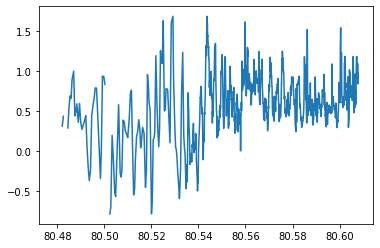

In [14]:
%matplotlib inline
al=30;
le=1500;

plt.plot(ds1r.lat[al:al+le],elev[al:al+le])#,'.')

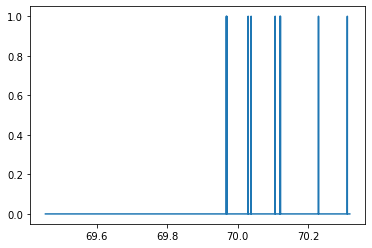

In [15]:
#%matplotlib widget
al=212000;
le=10000;

plt.plot(ds1r.lat[al:al+le],ds1r.isita_lead[al:al+le])#,'.')

In [16]:
%matplotlib widget

def f(al,le):
    plt.plot(ds1r.seg_dist[al:al+le]/1000,elev[al:al+le])#,'.')

In [17]:
# interactive_plot = interactive(f, al=8000, le=300)
# interactive_plot

In [18]:
ds1r.quality_flag

<xarray.DataArray 'quality_flag' (segs: 227904)>
array([-1, -1,  4, ..., -1, -1,  2], dtype=int8)
Coordinates:
    lon         (segs) float64 -0.271 -0.2715 -0.2722 ... -165.3 -165.3 -165.3
    lat         (segs) float64 80.2 80.2 80.2 80.2 ... 68.92 68.92 68.92 68.92
    time        (segs) datetime64[ns] 2018-12-02T12:06:11 ... 2018-12-02T12:14:14
    delta_time  (segs) float64 2.899e+07 2.899e+07 ... 2.899e+07 2.899e+07
    lon360      (segs) float64 359.7 359.7 359.7 359.7 ... 194.7 194.7 194.7
  * segs        (segs) int64 0 1 2 3 4 5 ... 227899 227900 227901 227902 227903

FigureCanvasNbAgg()

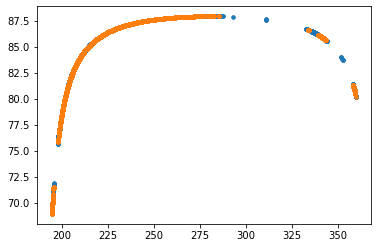

In [19]:
plt.plot(ds1r.lon360,ds1r.lat,'.',ds1l.lon360,ds1l.lat,'.')

FigureCanvasNbAgg()

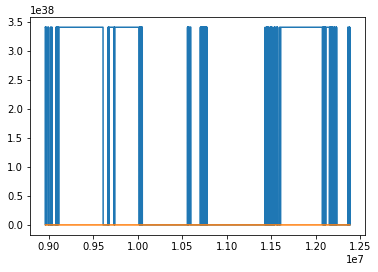

In [20]:
plt.plot(ds1r.seg_dist,ds1r.height,ds1l.seg_dist,ds1l.mss)

In [21]:
#%matplotlib widget
al=214800;
le=1000;

xshort = ds1r.seg_dist[al:al+le]
xshort = xshort - xshort[0]

dx = npy.diff(xshort)

latshort = ds1r.lat[al:al+le]
elevshort = elev[al:al+le]
concshort = ds1r.conc[al:al+le]/100

plt.plot(xshort,elevshort)#,'.')
plt.plot(xshort,concshort)

NameError: name 'npy' is not defined

FigureCanvasNbAgg()

Peak Wavenumber is 0.00510764039686486 1/m
Peak Wavelength is 62.3203400104623 m


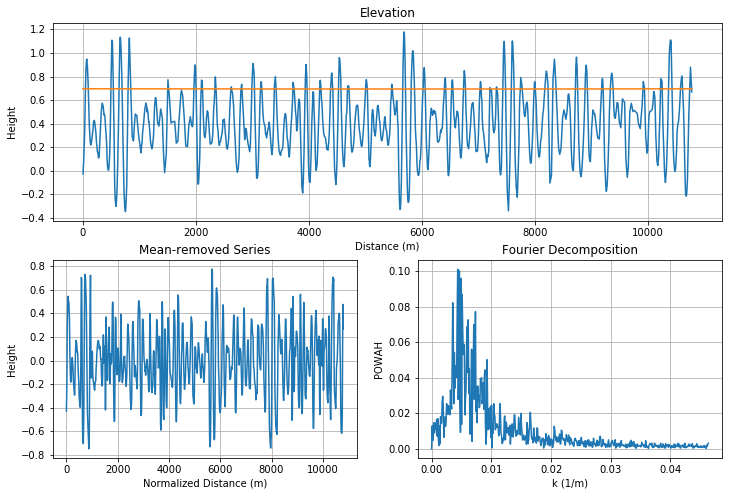

In [35]:
import scipy.fftpack

al=214800;
le=1000;

xshort = ds1r.seg_dist[al:al+le]
xshort = xshort - xshort[0]

dx = np.diff(xshort)
dx = dx.mean()

latshort = ds1r.lat[al:al+le]
elevshort = elev[al:al+le]
concshort = ds1r.conc[al:al+le]/100

f = plt.figure(figsize=(12,8))

ax0 = f.add_subplot(211)
ax1 = f.add_subplot(223)
ax2 = f.add_subplot(224)

N = len(xshort)
# sample spacing
xmod = np.linspace(0.0,N*dx,N)

y = elevshort - elevshort.mean()
yf = scipy.fftpack.fft(y)

xf = np.linspace(0.0, 1.0/(2.0*dx), N//2)

ax0.plot(xshort,elevshort)
ax0.plot(xshort,concshort)
ax0.set_title('Elevation')
ax0.set_xlabel('Distance (m)')
ax0.set_ylabel('Height')
ax0.grid()

# axs[1].subplot(2,1,1)
ax1.plot(xmod,y)
ax1.set_title('Mean-removed Series')
ax1.set_xlabel('Normalized Distance (m)')
ax1.set_ylabel('Height')
ax1.grid()

# plt.subplot(2,1,2)
ax2.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
# ax2.loglog(np.divide(1,xf), 2.0/N * np.abs(yf[0:N//2]))
ax2.grid()
ax2.set_title('Fourier Decomposition')
ax2.set_xlabel('k (1/m)')
ax2.set_ylabel('POWAH')

maxcal = np.argmax(yf[0:N//2])
max_f = xf[maxcal]
max_lam = 1/(np.pi*max_f)

print('Peak Wavenumber is ' + str(max_f) + ' 1/m')
print('Peak Wavelength is ' + str(max_lam) + ' m')


FigureCanvasNbAgg()

Peak Wavenumber is 0.008783798137373415 1/m
Peak Wavelength is 36.23829705619506 m


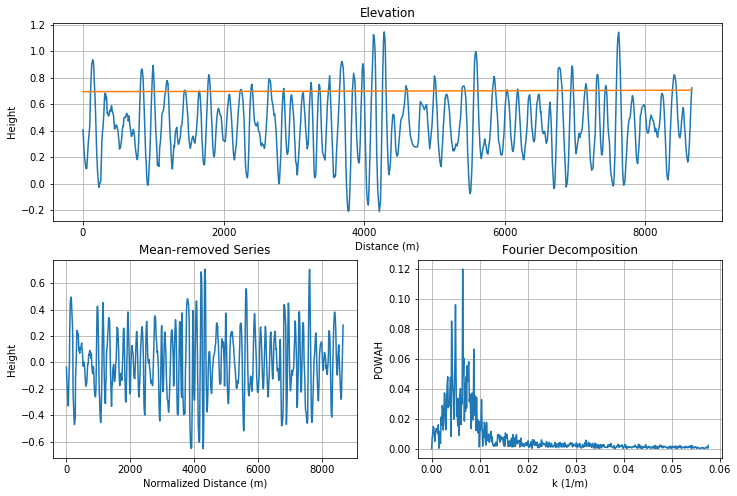

In [36]:
import scipy.fftpack

al_2=215800;
le_2=1000;

xshort_2 = ds1r.seg_dist[al_2:al_2+le_2]
xshort_2 = xshort_2 - xshort_2[0]

dx_2 = np.diff(xshort_2)
dx_2 = dx_2.mean()

latshort_2 = ds1r.lat[al_2:al_2+le_2]
elevshort_2 = elev[al_2:al_2+le_2]
concshort_2 = ds1r.conc[al_2:al_2+le_2]/100

f = plt.figure(figsize=(12,8))

ax0 = f.add_subplot(211)
ax1 = f.add_subplot(223)
ax2 = f.add_subplot(224)

N_2 = len(xshort)
# sample spacing
xmod_2 = np.linspace(0.0,N_2*dx_2,N_2)

y_2 = elevshort_2 - elevshort_2.mean()
yf_2 = scipy.fftpack.fft(y_2)

xf_2 = np.linspace(0.0, 1.0/(2.0*dx_2), N_2//2)

ax0.plot(xshort_2,elevshort_2)
ax0.plot(xshort_2,concshort_2)
ax0.set_title('Elevation')
ax0.set_xlabel('Distance (m)')
ax0.set_ylabel('Height')
ax0.grid()

# axs[1].subplot(2,1,1)
ax1.plot(xmod_2,y_2)
ax1.set_title('Mean-removed Series')
ax1.set_xlabel('Normalized Distance (m)')
ax1.set_ylabel('Height')
ax1.grid()

# plt.subplot(2,1,2)
ax2.plot(xf_2, 2.0/N_2 * np.abs(yf_2[0:N_2//2]))
# ax2.loglog(np.divide(1,xf), 2.0/N * np.abs(yf[0:N//2]))
ax2.grid()
ax2.set_title('Fourier Decomposition')
ax2.set_xlabel('k (1/m)')
ax2.set_ylabel('POWAH')

maxcal_2 = np.argmax(yf_2[0:N_2//2])
max_f_2 = xf_2[maxcal_2]
max_lam_2 = 1/(np.pi*max_f_2)

print('Peak Wavenumber is ' + str(max_f_2) + ' 1/m')
print('Peak Wavelength is ' + str(max_lam_2) + ' m')

FigureCanvasNbAgg()

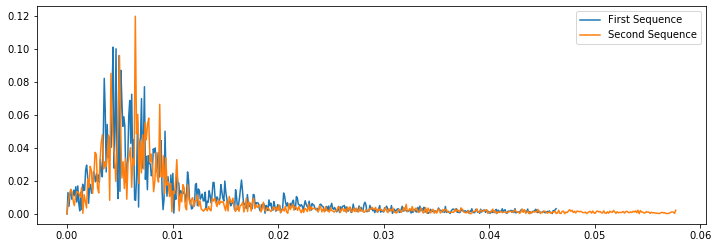

In [37]:
f = plt.figure(figsize=(12,4))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.plot(xf_2, 2.0/N_2 * np.abs(yf_2[0:N_2//2]))
plt.legend(('First Sequence','Second Sequence'))